# SECK Mouhamadou Abdoulaye
# abdouseck.tiv@gmail.com

## Auto-encoders

Pour ce premier exemple sur les auto-encodeurs nous utiliserons le jeu de donnée MNIST.  
Nous allons normaliser les données d'entrées et rajouter une dimension représentant les channels car les images sont en noir et blanc.

In [ ]:
import numpy as np
from keras.datasets import mnist
((xtrain, ytrain), (xtest, ytest)) = mnist.load_data()

xtrain = xtrain.astype('float32') / 255.
xtest = xtest.astype('float32') / 255.
print(f'xtrain shape before adding the "channels" dimension:{xtrain.shape}')
xtrain = np.reshape(xtrain, (len(xtrain), 28, 28, 1))
print(f'xtrain shape after adding the "channels" dimension:{xtrain.shape}')
xtest = np.reshape(xtest, (len(xtest), 28, 28, 1)) 

11493376/11490434 [==============================] - 0s 0us/step
xtrain shape before adding the "channels" dimension:(60000, 28, 28)
xtrain shape after adding the "channels" dimension:(60000, 28, 28, 1)


In [ ]:
np.shape(xtrain[0])

(28, 28, 1)

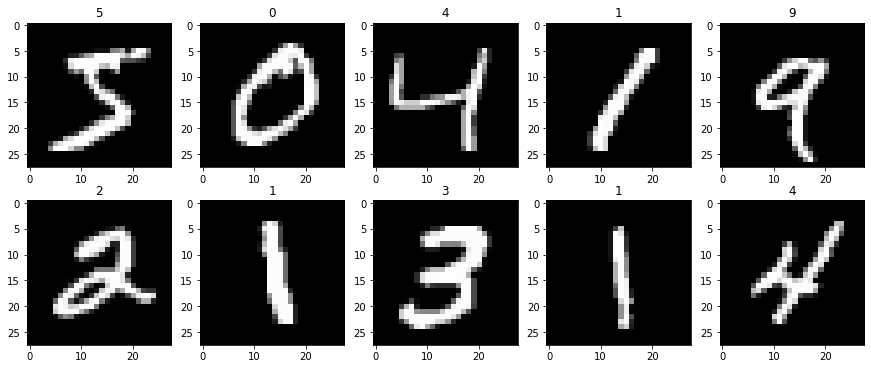

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.title(f"{ytrain[i]}")
  plt.imshow(xtrain[i].reshape(28, 28), cmap="gray")
plt.show()

Les auto-encodeurs sont des réseaux de neurones utilisés le plus souvent pour apprendre de façon non-supervisée ou faiblement supervisée une représentation (features/encodages) d'un jeu de données.  
Les auto-encodeurs sont généralement constitués de deux éléments:
* Un encodeur, chargé de réprésenter les données dans un espace le plus souvent de dimension réduite
* Un décodeur, capable à partir d'une donnée encodée de reconstruire la donnée initiale
![Source wikipedia](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)


Le code suivant instancie un décodeur.  
Nous avions l'habitude de construire des réseaux de neurones à l'aide de la classe ```Sequential``` de Keras.  Nous allons cette fois-ci utiliser la methode fonctionnelle en important la clase ```Model``` de Keras.  
Cette méthode offre un peu plus de souplesse que sequentielle. Elle permet notamment de définir un modèle comme une composition de fonctions/couches.  
Définissons le modèle de notre encodeur de cette manière.


In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

# On commence par définir une couche d'entrées
input_img = Input(shape=(28, 28, 1))
# On definit ensuite les couches suivantes à la manière d'un graph: couche = TypeDeCouche(paramètres_de_la_couche)(CouchePrécédente)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# On définit alors le model à partir de sa couche d'entrée et sa couche de sortie
encoder = Model(input_img, encoded)

L'encodeur reçoit donc en entrée une image de taille ```28*28```. A partir de cette image il va produire une representation de plus petite dimension.  
Cette representation est ce que l'on appelle les **features**.  
Regardons la dimension de la sortie de notre encodeur:

In [ ]:
print(encoder.predict(xtrain[:2]).shape)

(2, 4, 4, 8)


En nous inspirant du code utiliser pour définir le décodeur, vous allez maintenant coder nous même le décodeur en utilisant l'API Model de Keras.  
Nous utiliserons une nouvelle couche proposée dans l'API de Keras, la couche [UpSampling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D) permettant d'augmenter la taille d'un tenseur en répétant ses lignes et ses colonnes.  
Le décodeur sera composé des couches suivantes:
* Une couche d'inputs faite pour recevoir des tenseurs de la dimension des encodages générés par l'encodeur
* Une couche Conv2D 8 filtres, kernel (3,3) activation ReLU et padding=same
* Une couche UpSampling2D((2,2))
* Une couche Conv2D 8 filtres, kernel (3,3) activation ReLU et padding=same
* Une couche UpSampling2D((2,2))
* Une couche Conv2D 16 filtres, kernel (3,3) activation ReLU
* Une couche UpSampling2D((2,2))
* Une couche Conv2D 1 filtre, kernel (3,3) activation Sigmoid et padding=same

La couche de sigmoïde permettra d'obtenir des sorties comprises entre 0 et 1.

In [ ]:
from tensorflow.keras.layers import UpSampling2D

input_dec = Input(shape=(4, 4, 8))
x = Conv2D(8, (3, 3), activation="relu", padding="same")(input_dec)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation="relu")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

decoder = Model(input_dec, decoded)

Vérifiez que la sortie de votre décodeur est bien de la forme ```(batch_size, 28, 28, 1)```


In [ ]:
batch_size = 16
y = encoder.predict(xtrain[:batch_size])
decoder.predict(y).shape

(16, 28, 28, 1)

Nous pouvons maintenant créer un seul model à partir des deux précédents toujours en utilisant Model de Keras

In [ ]:
auto_encoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))

C'est normal d'avoir une image bruitée car nous n'avons pas encore entrainé nôtre auto-encodeur.

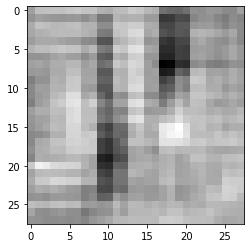

In [ ]:
plt.imshow(auto_encoder.predict(xtrain[:1]).reshape(28, 28), cmap="gray")
plt.show()

Entrainons maintenant le modèle entier.  
Sagissant d'une tache de reconstruction celà revient à prédire la valeur prise par chaque pixel de notre image de sortie.  
Les images étant des pixels prennant la valeur 1 ou 0, nous utiliserons donc la binary_crossentropy de Keras qui sera appliquée sur chacun des pixels.

In [ ]:
auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')
auto_encoder.fit(xtrain, xtrain, epochs=25, batch_size=128, shuffle=True, validation_data=(xtest, xtest))

Epoch 1/25
469/469 [==============================] - 3s 6ms/step - loss: 0.3186 - val_loss: 0.1504
Epoch 2/25
469/469 [==============================] - 2s 5ms/step - loss: 0.1446 - val_loss: 0.1303
Epoch 3/25
469/469 [==============================] - 2s 5ms/step - loss: 0.1288 - val_loss: 0.1211
Epoch 4/25
469/469 [==============================] - 2s 5ms/step - loss: 0.1207 - val_loss: 0.1158
Epoch 5/25
469/469 [==============================] - 2s 5ms/step - loss: 0.1161 - val_loss: 0.1118
Epoch 6/25
469/469 [==============================] - 2s 5ms/step - loss: 0.1126 - val_loss: 0.1093
Epoch 7/25
469/469 [==============================] - 2s 5ms/step - loss: 0.1103 - val_loss: 0.1078
Epoch 8/25
469/469 [==============================] - 2s 5ms/step - loss: 0.1084 - val_loss: 0.1060
Epoch 9/25
469/469 [==============================] - 2s 5ms/step - loss: 0.1070 - val_loss: 0.1048
Epoch 10/25
469/469 [==============================] - 2s 5ms/step - loss: 0.1056 - val_loss: 0.1040

Nous avons entrainé le model auto-encoder, composé lui même de deux sous-models. 
L'encodeur encode donc les images dans des tenseurs de dimension ```(batch_size,4,4,8)```.  
A partir de ces encodages le décodeur est capable de reconstituer l'image de départ.


In [ ]:
ztest = encoder.predict(xtest)
ypred = decoder.predict(ztest)
print(f'encodages ztest: {ztest.shape}')
print(f'prédictions ypred: {ypred.shape}')

encodages ztest: (10000, 4, 4, 8)
prédictions ypred: (10000, 28, 28, 1)


Le code suivant nous permet de visualiser le résultat de notre apprentissage sur quelques exemples:

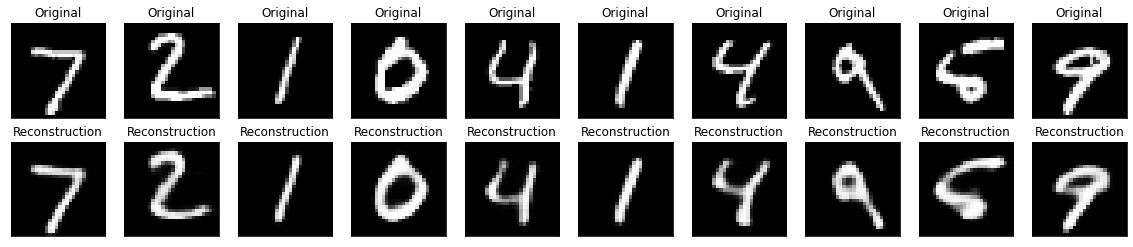

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(xtest[i].reshape(28, 28), cmap='gray')
    plt.title('Original')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(ypred[i].reshape(28, 28), cmap='gray')
    plt.title('Reconstruction')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoising auto-encoder
Nous allons maintenant utiliser des auto-encodeurs pour débruiter des images.  
Commençons pour cela par générer des images bruitées.  
Utilisez la fonction [random.normal](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html) de numpy pour rajouter un bruit gaussien sur une copie de x_train et de x_test. Utilisez un bruit centré avec un ecart type de 0.5.  
Afin que les images bruitées soient toujours comprises entre 0 et 1 utilisez la fonction [clip](https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html) de numpy toujours pour caper les données bruitées que vous venez de générer.


In [ ]:
import numpy as np
import numpy.random as npr

In [ ]:
print(np.shape(xtrain))
print(np.shape(xtest))

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
xtrain_noisy = xtrain + npr.normal(0, 0.5, (60000, 28, 28, 1))
xtest_noisy = xtest + npr.normal(0, 0.5, (10000, 28, 28, 1))
# n'oubliez pas de clipper les valeurs obtenues
xtrain_noisy = np.clip(xtrain_noisy, 0, 1)
xtest_noisy = np.clip(xtest_noisy, 0, 1)

Verifiez vos images perturbées en en affichant quelques unes

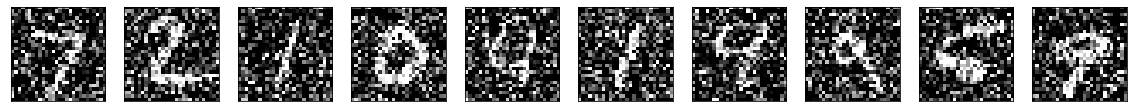

In [ ]:
plt.figure(figsize=(20, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(xtest_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Entrainez votre auto-encodeur à débruiter les images perturbées que vous venez de générer. (x: les images bruitées, target: les images non-bruitées)

In [ ]:
input_img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_img, encoded)

input_dec = Input(shape=(4, 4, 8))
x = Conv2D(8, (3, 3), activation="relu", padding="same")(input_dec)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation="relu")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

decoder = Model(input_dec, decoded)

auto_encoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')
auto_encoder.fit(xtrain_noisy, xtrain, epochs=50, batch_size=128, shuffle=True, validation_data=(xtest_noisy, xtest))

Epoch 1/50
469/469 [==============================] - 3s 5ms/step - loss: 0.3383 - val_loss: 0.1918
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1842 - val_loss: 0.1691
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1675 - val_loss: 0.1605
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1597 - val_loss: 0.1546
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1542 - val_loss: 0.1508
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1502 - val_loss: 0.1461
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1470 - val_loss: 0.1444
Epoch 8/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1444 - val_loss: 0.1415
Epoch 9/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1423 - val_loss: 0.1403
Epoch 10/50
469/469 [==============================] - 2s 5ms/step - loss: 0.1406 - val_loss: 0.1378

Affichez le résultat de votre apprentissage en affichant quelques images bruitées et leur déébruitage par l'auto encodeur

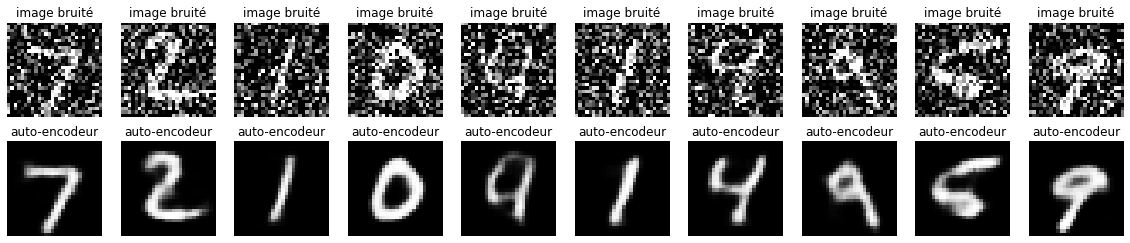

In [ ]:
decoded_imgs = auto_encoder.predict(xtest_noisy)

plt.figure(figsize=(20, 4))
for i in range(10):
  plt.subplot(2, 10, i+1)
  plt.title("image bruité")
  plt.imshow(xtest_noisy[i].reshape(28, 28), cmap="gray")
  plt.axis("off")

  plt.subplot(2, 10, 10+i+1)
  plt.title("auto-encodeur")
  plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
  plt.axis("off")
plt.show()

Les resultats sont un peu flous.
Vous pouvez essayer d'améliorer les reconstructions en augmentant la capacité de vos réseaux, par exemple en rajoutant des filtres lors des couches de convolutions

In [ ]:
input_img = Input(shape=(28, 28, 1))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_img, encoded)

input_dec = Input(shape=(4, 4, 16))
x = Conv2D(16, (3, 3), activation="relu", padding="same")(input_dec)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

decoder = Model(input_dec, decoded)

auto_encoder2 = Model(inputs=encoder.input, outputs=decoder(encoder.output))
auto_encoder2.compile(optimizer='adam', loss='binary_crossentropy')

auto_encoder2.fit(xtrain_noisy, xtrain, epochs=50, batch_size=128, shuffle=True, validation_data=(xtest_noisy, xtest))

Epoch 1/50
469/469 [==============================] - 5s 10ms/step - loss: 0.2635 - val_loss: 0.1464
Epoch 2/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1426 - val_loss: 0.1302
Epoch 3/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1288 - val_loss: 0.1229
Epoch 4/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1227 - val_loss: 0.1174
Epoch 5/50
469/469 [==============================] - 4s 10ms/step - loss: 0.1181 - val_loss: 0.1145
Epoch 6/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1152 - val_loss: 0.1132
Epoch 7/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1134 - val_loss: 0.1108
Epoch 8/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1116 - val_loss: 0.1098
Epoch 9/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1101 - val_loss: 0.1085
Epoch 10/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1089 - val_loss: 0.10

Affichez vos nouveaux résultats:

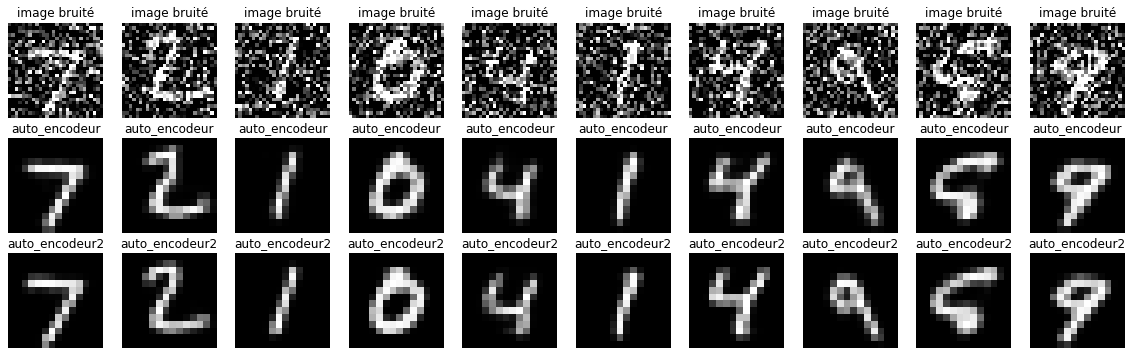

In [ ]:
decoded_imgs2 = auto_encoder2.predict(xtest_noisy)

plt.figure(figsize=(20, 6))
for i in range(10):
  plt.subplot(3, 10, i+1)
  plt.title("image bruité")
  plt.imshow(xtest_noisy[i].reshape(28, 28), cmap="gray")
  plt.axis("off")

  plt.subplot(3, 10, 10+i+1)
  plt.title("auto_encodeur")
  plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
  plt.axis("off")

  plt.subplot(3, 10, 20+i+1)
  plt.title("auto_encodeur2")
  plt.imshow(decoded_imgs2[i].reshape(28, 28), cmap="gray")
  plt.axis("off")
plt.show()

In [ ]:
ytest[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

## U-net
Nous allons maintenant nous concentrer sur une architecture particulière d'auto-encodeurs: les réseaux U-net.  
Les réseaux U-nets sont des auto-encodeurs ayant la particularité de posséder des connections directes entre les couches de l'encodeur et les couches du décodeur.  
![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Architecture-of-the-U-Net-Generator-Model.png)  
Les couches de convolutions du décodeur vont recevoir en entrées les sorties des couches qui les précèdent ainsi que les sorties des couches de convolutions correspondantes de l'encodeur.

Nous allons utiliser un réseau U-net pour recoloriser des images en noir et blanc.
Nous utiliserons le dataset [landscape](https://github.com/ml5js/ml5-data-and-models/tree/master/datasets/images/landscapes) composé de 4000 images de paysages.  
Commençons donc par télécharger le dataset.

In [ ]:
!wget https://github.com/ml5js/ml5-data-and-models/raw/master/datasets/images/landscapes/landscapes_small.zip
!mkdir landscapes
!unzip landscapes_small.zip -d landscapes
!rm -r landscapes/__MACOSX

Le dataset est uniquement constitué d'images en couleurs.  
Nous allons nous même générer les images en noir et blanc à l'aide de l'option ```color_mode``` des ```
ImageDataGenerator```.  
Nous allons utiliser ici 4 générateurs: deux fournissant des images en couleurs et deux des images en noir et blanc.  
Les générateurs utiliseront la même seed afin que les images en noir et blanc et en couleurs se correspondent.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

input_dir = 'landscapes'

seed = 1
 
color_datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.1)
bw_datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.1)
                                

train_color_generator = color_datagen.flow_from_directory(input_dir,
                                                          class_mode=None,
                                                          seed=seed,
                                                          subset='training',
                                                          target_size=(256, 256))

train_bw_generator = bw_datagen.flow_from_directory(input_dir,
                                                    color_mode='grayscale',
                                                    class_mode=None,
                                                    seed=seed,
                                                    subset='training',
                                                    target_size=(256, 256))

valid_color_generator = color_datagen.flow_from_directory(input_dir,
                                                          class_mode=None,
                                                          seed=seed,
                                                          subset='validation',
                                                          target_size=(256, 256))

valid_bw_generator = bw_datagen.flow_from_directory(input_dir,
                                                    color_mode='grayscale',
                                                    class_mode=None,
                                                    seed=seed,
                                                    subset='validation',
                                                    target_size=(256, 256))

train_generator = (pair for pair in zip(train_bw_generator, train_color_generator))
validation_generator = (pair for pair in zip(valid_bw_generator, valid_color_generator))

Found 3405 images belonging to 7 classes.
Found 3405 images belonging to 7 classes.
Found 376 images belonging to 7 classes.
Found 376 images belonging to 7 classes.


Regardons un exemple du de la sortie de nos générateurs

(32, 256, 256, 1) (32, 256, 256, 3)
0.0 1.0 0.0 1.0


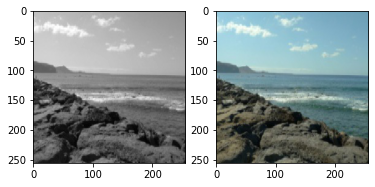

In [ ]:
x, y = next(train_generator)
print(x.shape, y.shape)
print(x.min(), x.max(), y.min(), y.max())
 
fig, (ax1, ax2) = plt.subplots(1, 2)
idx = np.random.randint(0, len(x))
ax1.imshow(np.squeeze(x[idx], axis=-1), cmap='gray')
ax2.imshow(y[idx])

L'un des avantages de la construction fonctionnelle en Keras est de permettre la definition de fonctions composées facilement réutilisables.  
En voici un exemple: la fonction suivante permet de combiner une couche de convolution suivie d'une batchnormalisation en un seul appel: 

In [ ]:
from tensorflow.keras.layers import BatchNormalization

def downsampling(input, filters):
    d = Conv2D(filters, kernel_size=4, strides=2, padding='same', activation='relu')(input)
    d = BatchNormalization()(d)
    return d

Codez une fonction ```upsampling(layer_input, skip_input, filters)``` qui reçoit deux entrées:
* Une de sa couche précédente
* Une de la couche de l'encodeur correspondante  


La fonction doit alors:
* Faire un UpSampling de ```input``` suivit d'une Convolution avec fonction d'activation ReLU puis d'une Batch Normalisation.
Utilisez un ```kernel_size=4``` un ```strides=1``` et ```padding='same'``` lors de la convolution afin que la sortie soit de la même taille que ```skip_input``` 
* [Concatener](https://keras.io/layers/merge/) la sortie de la Batch Normalisation avec ```skip_input```  (exemple: ```a = Concatenate()([a, b])```  

In [ ]:
from tensorflow.keras.layers import Concatenate

def upsampling(layer_input, skip_input, filters):
    u = UpSampling2D((2, 2))(layer_input)
    u = Conv2D(filters, kernel_size=4, strides=1, padding="same", activation="relu")(u)
    u = BatchNormalization()(u)
    u = Concatenate()([u, skip_input])
    return u

Vous allez maintenant définir votre réseau U-net en vous appuyant sur le shéma suivant:
![](https://drive.google.com/uc?id=1F1uuhhRnXhV53aR1chU41Z17krRt2cuU)

In [ ]:
x, y = next(train_generator)
print(np.shape(x))
print(np.shape(y))

(32, 256, 256, 1)
(32, 256, 256, 3)


In [ ]:
# Image input
d0 = Input(shape=(256, 256, 1))
 
# Downsampling
# d = downsampling(couche précédente, 32)
d1 = downsampling(d0, 32)
d2 = downsampling(d1, 64)
d3 = downsampling(d2, 128)
d4 = downsampling(d3, 128)
d5 = downsampling(d4, 256)
d6 = downsampling(d5, 256)
d7 = downsampling(d6, 256)
 
# Upsampling
# u = upsampling(couche_precedente, couche_equivalente_decodeur, nb_filtres)
u1 = upsampling(d7, d6, 256)
u2 = upsampling(u1, d5, 256)
u3 = upsampling(u2, d4, 256)
u4 = upsampling(u3, d3, 128)
u5 = upsampling(u4, d2, 64)
u6 = upsampling(u5, d1, 32)
# Last upsampling
u7 = UpSampling2D(size=2)(u6)
u7 = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u7)
 
model = Model(d0, u7)
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=100, epochs=10, validation_data=validation_generator, validation_steps=10)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 49s 455ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.0947 - val_loss: 0.1442 - val_mse: 0.1442 - val_mae: 0.3062
Epoch 2/10
100/100 [==============================] - 48s 480ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0653 - val_loss: 0.1263 - val_mse: 0.1263 - val_mae: 0.2764
Epoch 3/10
100/100 [==============================] - 46s 456ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0634 - val_loss: 0.0502 - val_mse: 0.0502 - val_mae: 0.1821
Epoch 4/10
100/100 [==============================] - 46s 456ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0605 - val_loss: 0.0567 - val_mse: 0.0567 - val_mae: 0.1763
Epoch 5/10
100/100 [==============================] - 46s 458ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0598 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.1137
Epoch 6/10
100/100 [==============================] - 46s 457ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0589 - val_loss: 0.0136 - val_mse: 0.0136 - val_mae: 0.092

Affichez maintenant plusieurs exemples du résultat de votre apprentissage:


*   Image en noir et blanc
*   Image en couleur d'origine
*   Image recolorisée par le réseau



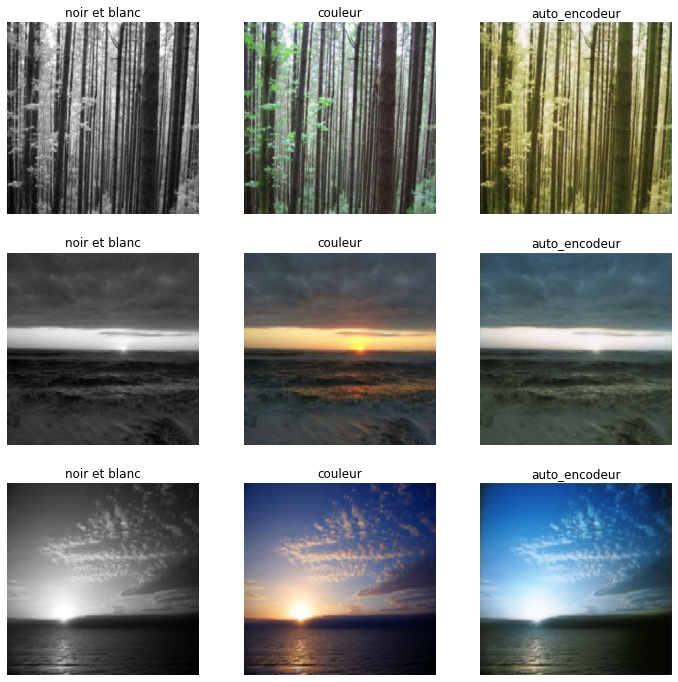

In [ ]:
x, y = next(validation_generator)
xpred = model.predict(x)

plt.figure(figsize=(12, 12))
for i in range(3):
  plt.subplot(3, 3, 3*i+1)
  plt.title("noir et blanc")
  plt.imshow(x[i].reshape(256, 256), cmap="gray")
  plt.axis("off")

  plt.subplot(3, 3, 3*i+2)
  plt.title("couleur")
  plt.imshow(y[i])
  plt.axis("off")

  plt.subplot(3, 3, 3*i+3)
  plt.title("auto_encodeur")
  plt.imshow(xpred[i])
  plt.axis("off")
plt.show()

Pour aller plus loin avec les auto-encodeurs:
* Un article bien détaillé sur une amélioration des auto-encodeurs permettant de générer des nouveaux exemples: [les variationals auto-encoders](http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/):
* Il y a quelques années un challenge Kaggle portait sur le débruitage de documents manuscrits: https://www.kaggle.com/c/denoising-dirty-documents/overview. Vous pouvez essayer d'utiliser des auto-encodeurs pour débruiter le dataset